In [1]:
# Import stuff
import os
import scipy
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import theano
from tqdm import tqdm, trange

cwd = os.getcwd()
os.chdir('/media/bigdata/firing_space_plot/ephys_data/')
from ephys_data import ephys_data
import visualize
os.chdir(cwd)

%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

In [2]:
data_dir = '/media/bigdata/Abuzar_Data/AS18/AS18_4Tastes_200229_154608'
dat = \
    ephys_data(data_dir)
dat.firing_rate_params = dat.default_firing_params

dat.get_unit_descriptors()
dat.get_spikes()
dat.get_firing_rates()

print(dat.default_firing_params)

All tastes have equal dimensions,concatenating and normalizing
{'type': 'conv', 'step_size': 25, 'window_size': 250, 'dt': 1, 'baks_resolution': 0.025, 'baks_dt': 0.001}


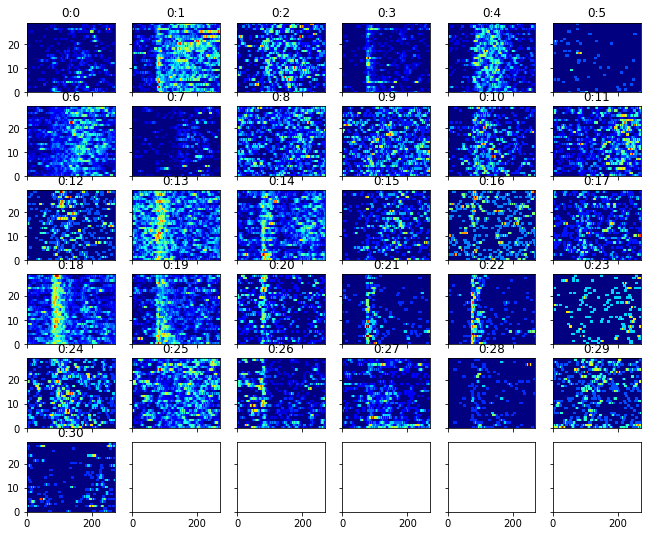

In [3]:
taste = 0
visualize.firing_overview(dat.firing_array[taste]);plt.show()

In [4]:
taste_dat = np.array(dat.spikes)
print(taste_dat.shape)
# Trial x Nrn x Time

(4, 30, 31, 7000)


In [5]:
# Convert spikes to counts by binning
time_lims = [2000,4000]
bin_width = 25
t_vec = np.arange(taste_dat.shape[-1])
binned_t_vec = np.mean(t_vec[time_lims[0]:time_lims[1]].reshape((-1,bin_width)),axis=-1)
this_dat_binned = np.sum(taste_dat[...,time_lims[0]:time_lims[1]].reshape(*taste_dat.shape[:-1],-1,bin_width),axis=-1)
this_dat_binned = np.vectorize(np.int)(this_dat_binned)
print(this_dat_binned.shape)

(4, 30, 31, 80)


(4, 30, 31, 80)


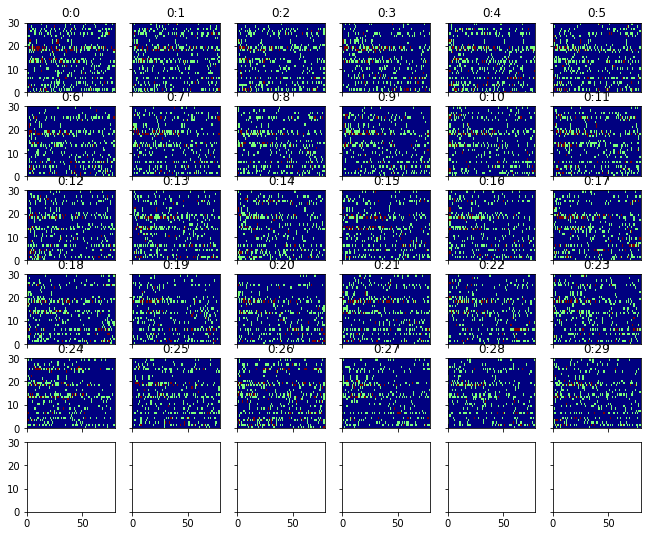

In [6]:
count_data = this_dat_binned

plot_dat = (count_data>0)*1 + (count_data>1)
visualize.firing_overview(plot_dat[0])

count_data = count_data>0
print(count_data.shape)
# Nrn X Time_bin

In [7]:
# Calculate mean vals by concatenating ALL tastes
states = 4
split_list = np.array_split(count_data,states,axis=-1)
# Cut all to the same size
min_val = min([x.shape[-1] for x in split_list])
split_array = np.array([x[...,:min_val] for x in split_list])
print(split_array.shape)
mean_vals = np.mean(split_array,axis=(1,2,-1))
mean_vals += 0.01 # To avoid zero starting prob
print(mean_vals.shape) # Trials x nrns
print(mean_vals)

(4, 4, 30, 31, 20)
(4, 31)
[[0.09416667 0.4225     0.17625    0.26916667 0.23041667 0.03541667
  0.34       0.03125    0.10375    0.13333333 0.14458333 0.16166667
  0.07125    0.555      0.45625    0.08291667 0.10916667 0.12833333
  0.62708333 0.50458333 0.20791667 0.15791667 0.18375    0.04083333
  0.12875    0.315      0.19291667 0.19208333 0.05875    0.08458333
  0.01708333]
 [0.07291667 0.30333333 0.1725     0.11708333 0.30916667 0.01916667
  0.30541667 0.03875    0.10416667 0.13333333 0.14416667 0.10583333
  0.09416667 0.39958333 0.33166667 0.06       0.05833333 0.10916667
  0.49041667 0.40875    0.10125    0.05625    0.06666667 0.03375
  0.14708333 0.28125    0.06208333 0.13916667 0.04625    0.08708333
  0.01375   ]
 [0.08208333 0.33958333 0.16041667 0.08833333 0.2875     0.015
  0.41791667 0.08833333 0.13375    0.15541667 0.13833333 0.1075
  0.06791667 0.29708333 0.21       0.08375    0.05416667 0.08875
  0.31541667 0.28583333 0.08208333 0.02625    0.02541667 0.02666667
  0.1358

In [8]:
idx = np.arange(count_data.shape[-1]) # Index
array_idx = np.broadcast_to(idx, count_data.shape[1:])
idx_range = idx.max() - idx.min()
print(idx.min())
print(idx.max())
print(array_idx.shape)

0
79
(30, 31, 80)


(4, 31)


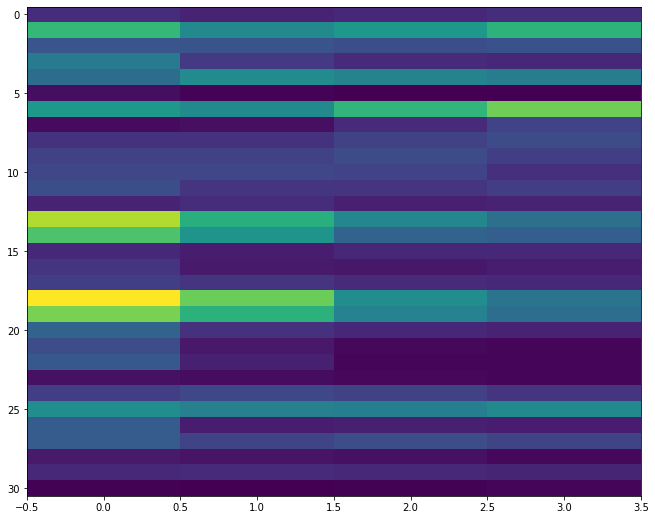

In [9]:

lambda_names = ['lambda_{}'.format(i+1) for i in range(states)]
with pm.Model() as model:
    
    
    # SAME LAMBDAS ACROSS ALL TRIALS
    # Finite, but somewhere on the lower end, Beta prior
    #a_lambda = pm.HalfNormal('a_lambda', 2.)
    #b_lambda = pm.HalfNormal('b_lambda', 5.)
    a_lambda = 2
    b_lambda = 5
    
    #lambda_latent = pm.math.stack(
    #                    [pm.Beta(lambda_names[i], a_lambda, b_lambda, testval = mean_vals[i], 
    #                               shape = (mean_vals.shape[1])) \
    #                     for i in range(states)]
    #)
    lambda_latent = pm.Beta('lambda', a_lambda, b_lambda, testval = mean_vals, 
                                   shape = (states,mean_vals.shape[1]))
    
print(lambda_latent.tag.test_value.shape)
plt.imshow(lambda_latent.tag.test_value.T,aspect='auto');

In [10]:
even_switches = np.linspace(0,idx.max(),states+1)
even_switches_normal = even_switches/np.max(even_switches)
print(even_switches)
print(even_switches_normal[1:(states)])

[ 0.   19.75 39.5  59.25 79.  ]
[0.25 0.5  0.75]


In [11]:
#tau_names = ['tau_{}'.format(i+1) for i in range(states-1)]
with model:
    
    
    # INDEPENDENT TAU FOR EVERY TRIAL
    a = pm.HalfNormal('a_tau', 3., shape = states - 1)
    b = pm.HalfNormal('b_tau', 3., shape = states - 1)
    
    #a_broad = tt.tile(a,(count_data.shape[1],1))
    #b_broad = tt.tile(b,(count_data.shape[1],1))
    
print(a.tag.test_value.shape)
#print(a_broad.tag.test_value.shape)
    
    # More specific hyperprior for each changepoint
    # E(x ~ Beta) = a/(a+b) = c
    # Constraint : a + b = 6 (pretty arbitrary), c <= 1 (property of distribution)
    #a = 6*c
    #b = 6-a
#     a_vec = even_switches_normal[1:(states)]*6
#     b_vec = 6 - a_vec
#     a_dist_vec = [pm.HalfNormal('a_tau_{}'.format(i), a_vec[i]) for i in range(len(a_vec))]
#     b_dist_vec = [pm.HalfNormal('b_tau_{}'.format(i), b_vec[i]) for i in range(len(b_vec))]
#     print(a_vec)
#     print(b_vec)

(3,)


In [13]:
with model:
    
    # Stack produces states x trials --> That gets transposed to trials x states and gets sorted along states (axis=-1)
    # Sort should work the same way as the Ordered transform --> see rv_sort_test.ipynb
    #tau_latent = pm.math.stack([
    #                   pm.Beta(tau_names[i], a_dist_vec[i], b_dist_vec[i], 
    #                           shape = count_data.shape[0], testval = even_switches_normal[1+i]) \
    #               for i in range(states-1)]).T.sort(axis=-1)
    
    #tau_latent = pm.Beta('tau_latent', a, b, 
    #                       shape = (states-1,count_data.shape[0])).T.sort(axis=-1)
    #tau_latent = pm.Beta('tau_latent', a_broad, b_broad, 
    tau_latent = pm.Beta('tau_latent', a, b, 
                           shape = (count_data.shape[1], states-1),
                            testval = np.tile(even_switches_normal[1:(states)], (count_data.shape[1],1))).sort(axis=-1)
    print(tau_latent.tag.test_value.shape)
       
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
print(tau.tag.test_value.shape)


(30, 3)
(30, 3)


(30, 31, 80)
(30, 31, 80)


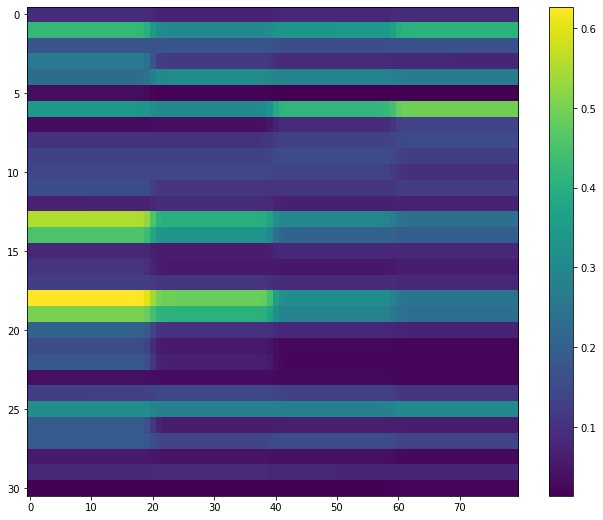

In [14]:
with model:
    
    # Assign lambdas to time_bin indices using sigmoids centered on switchpoints
    # Refer to https://www.desmos.com/calculator/yisbydv2cq
    
    weight_1_stack = tt.nnet.sigmoid(2 * (array_idx - tau[:,0][:,np.newaxis,np.newaxis]))
    weight_2_stack = tt.nnet.sigmoid(2 * (array_idx - tau[:,1][:,np.newaxis,np.newaxis]))
    weight_3_stack = tt.nnet.sigmoid(2 * (array_idx - tau[:,2][:,np.newaxis,np.newaxis]))
    #weight_4_stack = tt.nnet.sigmoid(2 * (array_idx - tau[:,3][:,np.newaxis,np.newaxis]))
    
    lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[0][np.newaxis,:,np.newaxis]) + \
                np.multiply(weight_1_stack * (1 - weight_2_stack), lambda_latent[1][np.newaxis,:,np.newaxis]) + \
                np.multiply(weight_2_stack * (1 - weight_3_stack), lambda_latent[2][np.newaxis,:,np.newaxis]) + \
                np.multiply(weight_3_stack, lambda_latent[3][np.newaxis,:,np.newaxis])
                #np.multiply(weight_3_stack * (1 - weight_4_stack), lambda_latent[3][np.newaxis,:,np.newaxis]) + \
                

print(weight_1_stack.tag.test_value.shape)
#print(weight_stack.tag.test_value.shape)
print(lambda_.tag.test_value.shape)
plt.imshow(lambda_.tag.test_value[0],aspect='auto');plt.colorbar();

In [15]:
# Using Bernoullo likelihood for count data
with model:
    data = pm.Data("data", count_data[0])
    observation = pm.Bernoulli("obs", lambda_, observed=data)

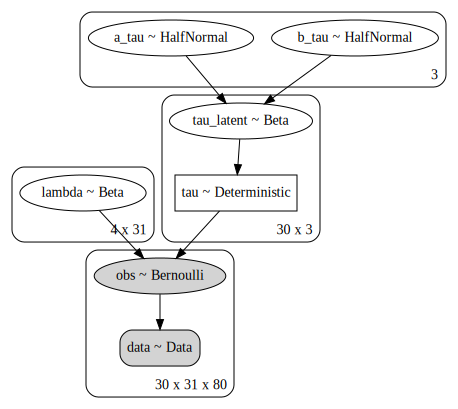

In [16]:
pm.model_to_graphviz(model)

In [17]:
traces = []
taste_num = 0
with model:
    # Switch out the observed dataset
    pm.set_data({"data": count_data[taste_num]})

    step= pm.NUTS()
    traces.append( pm.sample(2500, tune=500, 
                      step = step,
                      chains = 16, cores = 16))

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [tau_latent, b_tau, a_tau, lambda]
Sampling 16 chains, 0 divergences:   0%|          | 0/48000 [00:00<?, ?draws/s]/home/abuzarmahmood/ana

ValueError: Not enough samples to build a trace.

In [19]:
taste_num = 1
with model:
    # Switch out the observed dataset
    pm.set_data({"data": count_data[taste_num]})

    step= pm.NUTS()
    traces.append( pm.sample(2500, tune=500, 
                      step = step,
                      chains = 16, cores = 16))

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [tau_latent, b_tau, a_tau, lambda]
Sampling 16 chains, 0 divergences: 100%|██████████| 48000/48000 [2:33:45<00:00,  5.20draws/s]  
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [20]:
taste_num = 2
with model:
    # Switch out the observed dataset
    pm.set_data({"data": count_data[taste_num]})

    step= pm.NUTS()
    traces.append( pm.sample(2500, tune=500, 
                      step = step,
                      chains = 16, cores = 16))

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [tau_latent, b_tau, a_tau, lambda]
Sampling 16 chains, 272 divergences: 100%|██████████| 48000/48000 [7:45:46<00:00,  1.72draws/s]  
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.31722832603715745, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 86 divergences after tuning. Increase `target_accept` 

In [21]:
taste_num = 3
with model:
    # Switch out the observed dataset
    pm.set_data({"data": count_data[taste_num]})

    step= pm.NUTS()
    traces.append( pm.sample(2500, tune=500, 
                      step = step,
                      chains = 16, cores = 16))

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [tau_latent, b_tau, a_tau, lambda]
Sampling 16 chains, 2,684 divergences: 100%|██████████| 48000/48000 [9:20:33<00:00,  1.43draws/s]  
The acceptance probability does not match the target. It is 0.9129416104934637, but should be close to 0.8. Try to increase the number of tuning steps.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6278476310982675, but should be close to 0.8. Try to increase the number of tuning steps.
There were 25 diverg

In [22]:
print(traces[0]['tau_latent'].shape)

(40000, 30, 3)


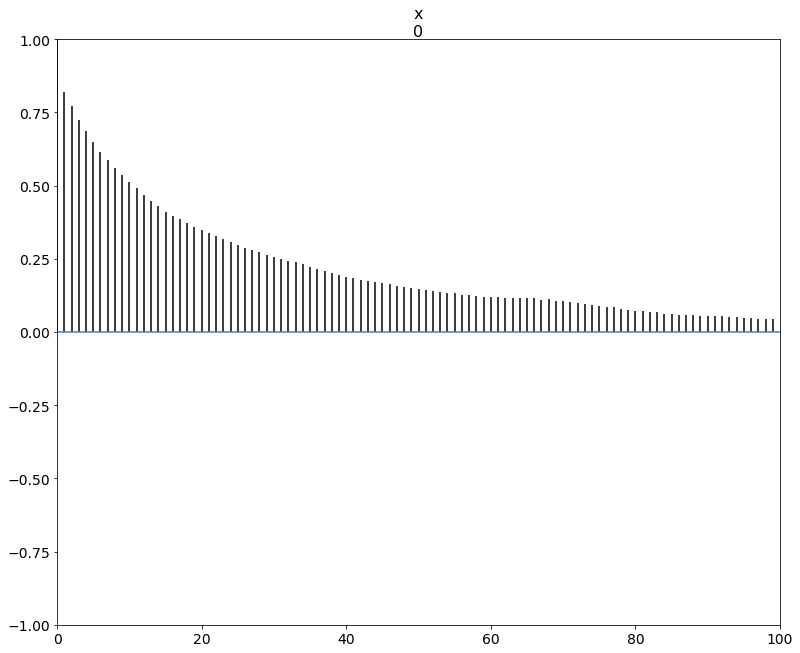

In [24]:
pm.autocorrplot(traces[0]['tau_latent'][:,0,0]);

In [38]:
traces_thinned = [trace[::10] for trace in traces]

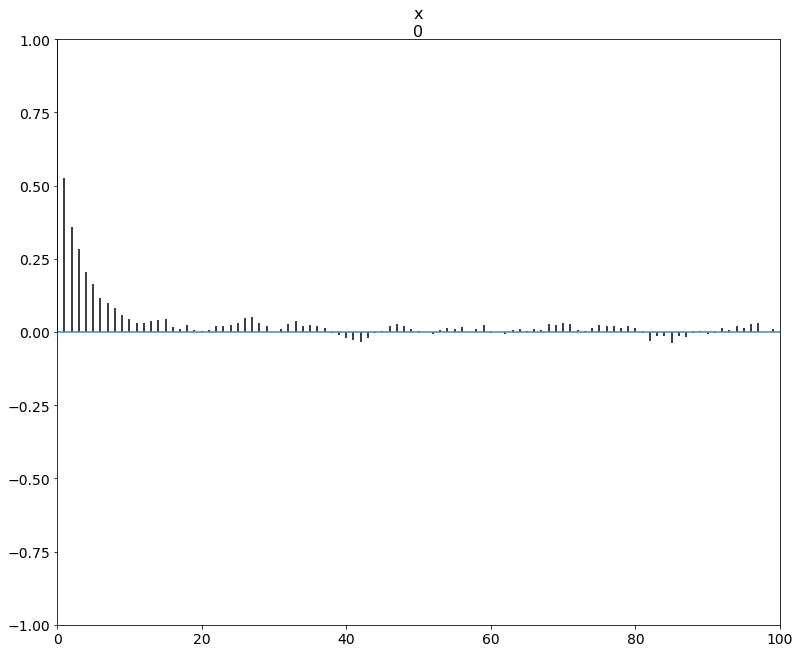

In [40]:
pm.autocorrplot(traces_thinned[0]['tau_latent'][:,0,0]);

In [50]:
traces = traces_thinned

In [51]:
for num, trace in enumerate(traces):
    pm.save_trace(trace,os.path.join(os.path.dirname(dat.hdf5_name),'nuts_mcmc_traces', f'taste_{num}'))

In [52]:
[len(x) for x in traces]

[250, 250, 250, 250]

In [53]:
print(traces[0]['tau_latent'].shape)

(4000, 30, 3)


In [54]:
# Save traces
# for num,x in enumerate(traces):
#     pm.save_trace(x,os.path.join(os.path.dirname(dat.hdf5_name),'mcmc_traces', f"taste_{num}"))

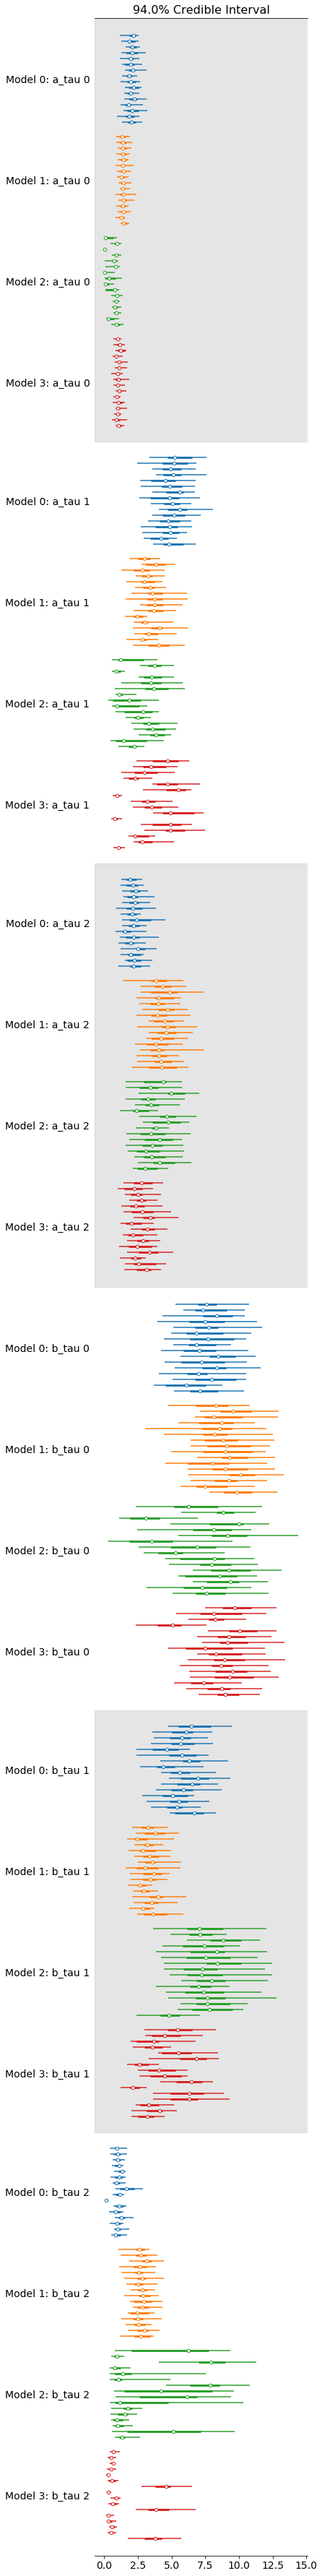

In [55]:
pm.forestplot([x[::10] for x in traces], var_names = ['a_tau','b_tau']);

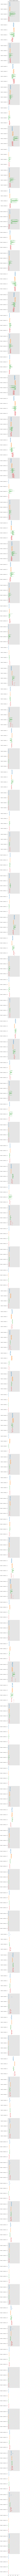

In [56]:
pm.forestplot([x[::10] for x in traces], var_names = ['lambda']);

In [ ]:
#pm.summary(trace[::100]).round(2)

In [57]:
lambda_stack_array = np.array([x['lambda'].swapaxes(0,1) for x in traces]) # tastes x states x samples x nrn
tau_samples_array = np.array([x['tau'] for x in traces]) # tastes x samples x trials x (states - 1)
print(lambda_stack_array.shape)
print(tau_samples_array.shape)

(4, 4, 4000, 31)
(4, 4000, 30, 3)


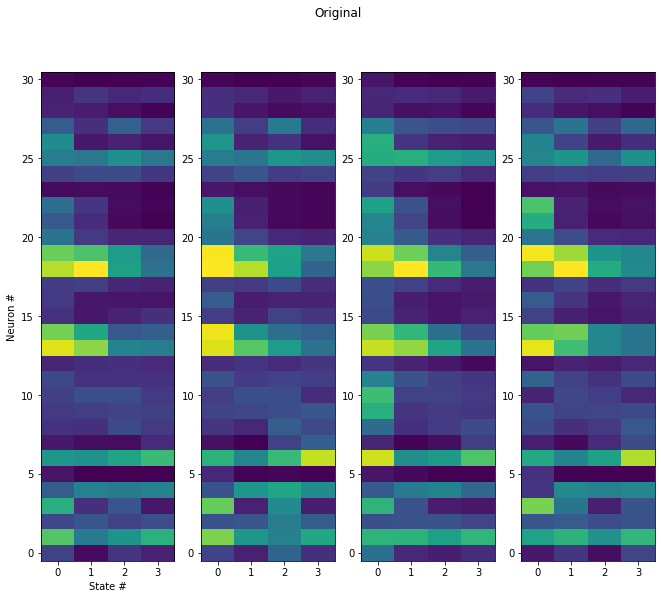

In [58]:
mean_lambda = np.mean(lambda_stack_array,axis=2)

fig, ax = plt.subplots(1,4)
for data, this_ax in zip(mean_lambda, ax.flatten()):
    this_ax.imshow(data.T, aspect='auto', origin='lower');
    plt.xticks(np.arange(mean_lambda.shape[0]));

ax[0].set_xlabel('State #');
ax[0].set_ylabel('Neuron #');
plt.suptitle('Original');

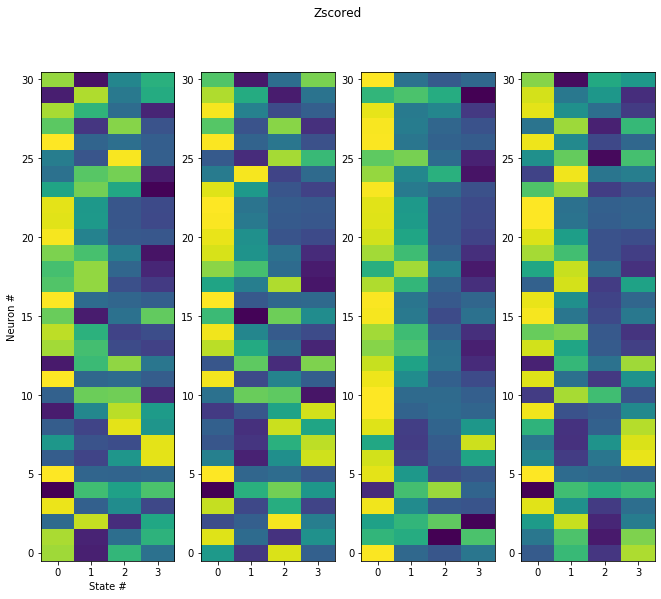

In [59]:
fig, ax = plt.subplots(1,4)
for data, this_ax in zip(mean_lambda, ax.flatten()):
    this_ax.imshow(stats.zscore(data.T,axis=-1), aspect='auto', origin='lower');
    plt.xticks(np.arange(mean_lambda.shape[0]));

ax[0].set_xlabel('State #');
ax[0].set_ylabel('Neuron #');
plt.suptitle('Zscored');

In [60]:
ppc_array = np.array([pm.sample_posterior_predictive(x, samples = 2000, model = model)['obs'] for x in traces])
ppc_array.shape

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 2000/2000 [00:34<00:00, 57.19it/s]
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 2000/2000 [00:33<00:00, 59.89it/s]


(4, 2000, 30, 31, 80)

In [61]:
mean_ppc = np.mean(ppc_array,axis=1)
mean_ppc_long = np.reshape(mean_ppc, (-1, *mean_ppc.shape[2:]))
std_ppc = np.std(ppc_array,axis=1)
print(mean_ppc.shape)
print(mean_ppc_long.shape)

(4, 30, 31, 80)
(120, 31, 80)


In [63]:
mean_tau = np.mean(tau_samples_array,axis=1)
long_tau_samples = tau_samples_array.reshape((tau_samples_array.shape[0],-1,tau_samples_array.shape[-1]))
long_tau_samples = long_tau_samples[:,::100]
print(mean_tau.shape)
print(long_tau_samples.shape)

(4, 30, 3)
(4, 1200, 3)


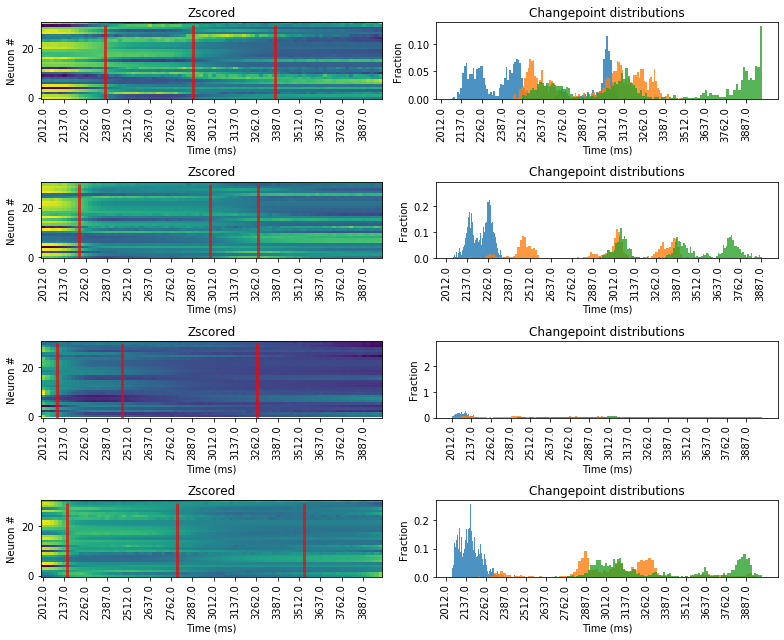

In [64]:
tick_interval = 5
fig,ax = plt.subplots(4,2)

for num, data in enumerate(mean_ppc):
    ax[num,0].imshow(stats.zscore(np.mean(data,axis=0),axis=-1), aspect='auto', origin='lower')
    plt.sca(ax[num,0])
    plt.xticks(np.arange(0,len(binned_t_vec),tick_interval),binned_t_vec[::tick_interval],rotation='vertical');
    plt.vlines(np.mean(mean_tau[num],axis=0),-0.5,count_data.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7);
    plt.xlabel('Time (ms)');
    plt.ylabel('Neuron #');
    plt.title('Zscored')

for num, tau in enumerate(long_tau_samples):
    for switch in range(tau.shape[-1]):
        ax[num,1].hist(long_tau_samples[num,:,switch],bins = 100, density = True,alpha = 0.8)
    plt.sca(ax[num,1])
    plt.xticks(np.arange(0,len(binned_t_vec),tick_interval),binned_t_vec[::tick_interval],rotation='vertical');
    plt.xlabel('Time (ms)');
    plt.ylabel('Fraction');
    plt.title('Changepoint distributions')
    plt.tight_layout()

In [65]:
zscore_mean_ppc = stats.zscore(mean_ppc,axis=-1)
zscore_ppc_long = np.reshape(zscore_mean_ppc, (-1, *zscore_mean_ppc.shape[2:]))
#zscore_mean_ppc = np.stack([stats.zscore(mean_ppc[:,nrn],axis=None) for nrn in range(mean_ppc.shape[1])]).swapaxes(0,1)
count_data_long = np.reshape(count_data, (-1, *count_data.shape[2:]))
mean_tau_long = np.reshape(mean_tau, (-1, *mean_tau.shape[2:]))
tau_samples_long = tau_samples_array.swapaxes(1,2)
tau_samples_long = np.reshape(tau_samples_long, (-1, *tau_samples_long.shape[2:]))
tau_samples_long = tau_samples_long
print(tau_samples_long.shape)
print(mean_tau_long.shape)
print(count_data_long.shape)
print(zscore_ppc_long.shape)

(120, 4000, 3)
(120, 3)
(120, 31, 80)
(120, 31, 80)


30it [00:05,  5.17it/s]


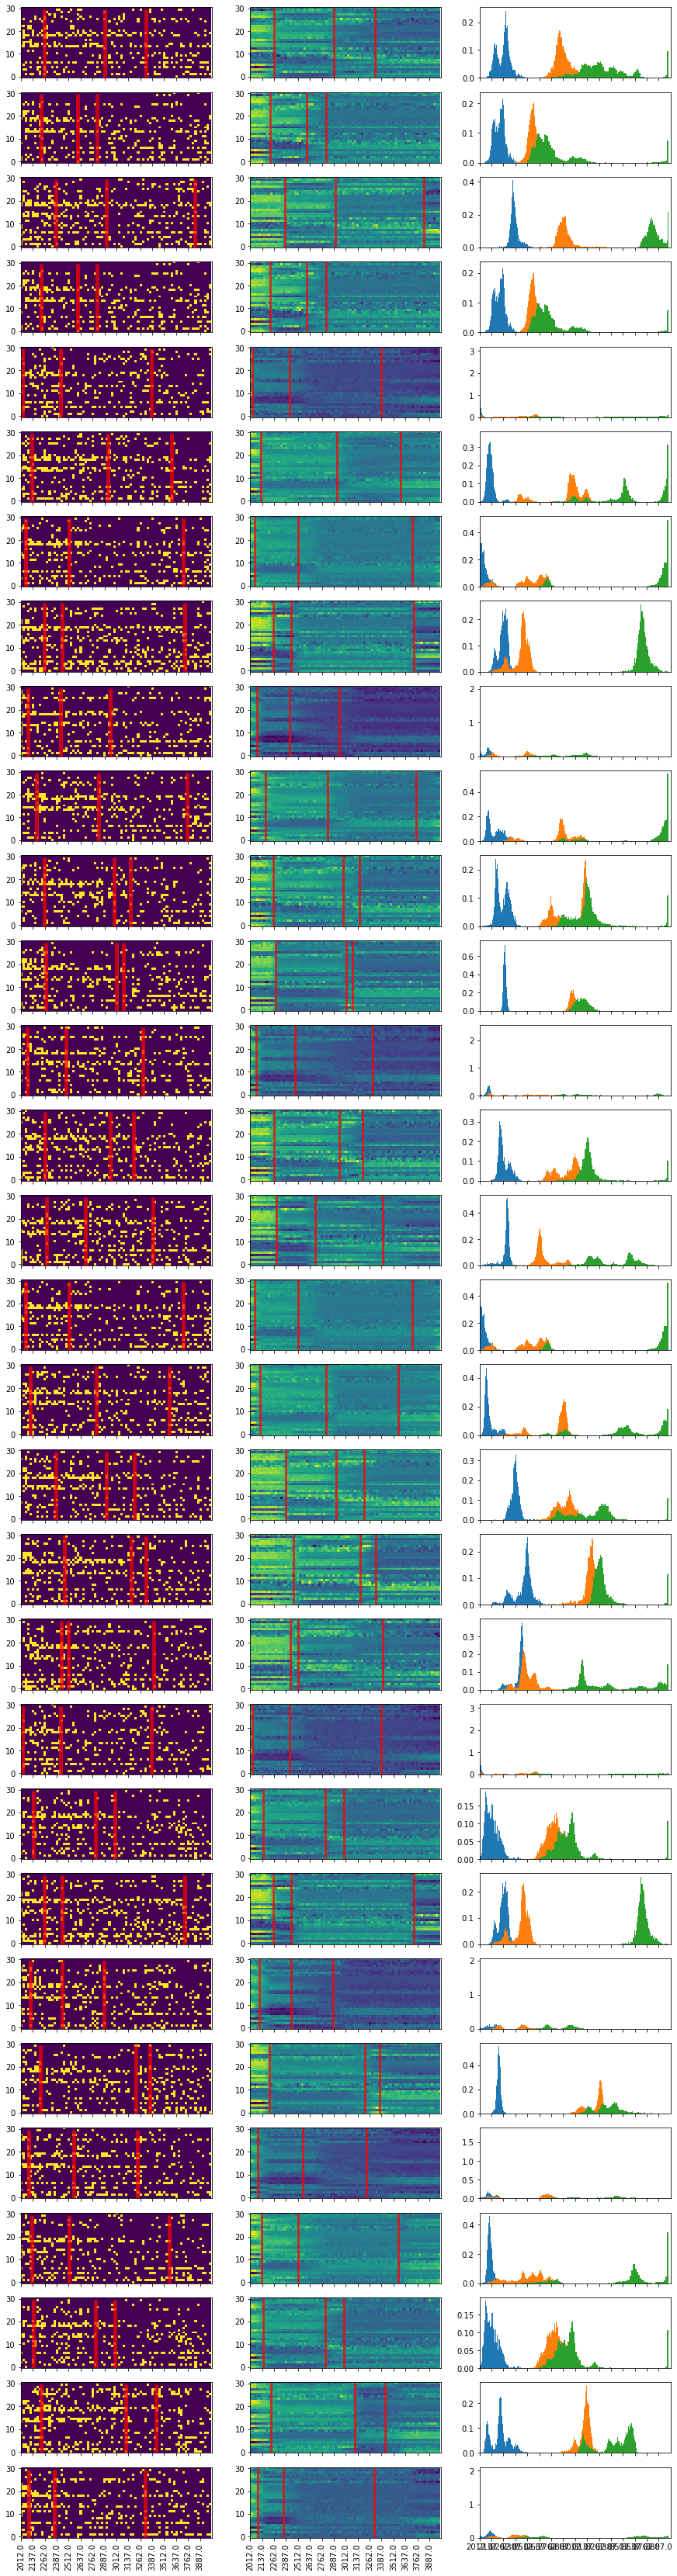

In [66]:
# Overlay raster with CDF of switchpoints
# Show random subset of trials

trial_count = 30
trial_inds = np.random.choice(np.arange(count_data_long.shape[0]), trial_count)

fig, ax = plt.subplots(trial_count, 3, figsize = (15,60), sharex=True)
for num,trial in tqdm(enumerate(trial_inds)):
    ax[num,0].imshow(count_data_long[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num,1].imshow(zscore_ppc_long[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num,1].vlines(mean_tau_long[trial],-0.5,count_data.shape[2]-0.5,color = 'red',linewidth = 3, alpha = 0.7)
    ax[num,0].vlines(mean_tau_long[trial],-0.5,count_data.shape[1]-0.5,color = 'red',linewidth = 5, alpha = 0.7)

    for state in range(tau_samples_long.shape[-1]):
        ax[num,2].hist(tau_samples_long[trial,:,state], bins = 100, density = True)

for col in range(2):
    plt.sca(ax[-1,col])
    plt.xticks(np.arange(0,len(binned_t_vec),tick_interval),binned_t_vec[::tick_interval],rotation='vertical');
    plt.xlim(0,len(binned_t_vec))

In [ ]:
# Compare ppc trial mean firing to sliding window for a sample of trials and neurons
# Generate time_vec for rolling window to index firing
firing_time_vec = np.vectorize(np.int)(7000* (np.arange(dat.all_firing_array.shape[-1])/dat.all_firing_array.shape[-1]))
# Index out firing between time_lims
firing_inds = np.where((time_lims[0] < firing_time_vec) * (firing_time_vec < time_lims[1]))[0]

# Convert spike_array to appropriate dimension
spike_array_long = np.reshape(taste_dat, (-1, *taste_dat.shape[2:]))
print(spike_array_long.shape)

samples = 40
all_rolling_firing = dat.all_firing_array.swapaxes(0,1)
print(all_rolling_firing.shape)
all_iters = list(np.ndindex(all_rolling_firing.shape[:2]))
selected_iter_inds = np.random.choice(np.arange(len(all_iters)),samples)
selected_iters = [all_iters[ind] for ind in selected_iter_inds]
print(selected_iters)

# Plot overlay of raster, firing rate, and mean ppc estimate of firing rate
fig, ax = visualize.gen_square_subplots(samples)
for this_iter, this_ax in zip(selected_iters, ax.flatten()):
    this_spikes = spike_array_long[this_iter]
    this_ax.scatter(np.where(this_spikes),[0]*int(sum(this_spikes)),c='r')
    this_ax.plot(firing_time_vec,stats.zscore(all_rolling_firing[this_iter],axis=-1), c='b')
    this_ax.plot(binned_t_vec,stats.zscore(mean_ppc_long[this_iter],axis=-1), c='orange')
    this_ax.set_xlim(*time_lims)
    

In [ ]:
# Find dominant state during 800-1200 ms post-stim
# We can do this visually by plotting the changepoint distribution
for switch in range(long_tau_samples.shape[-1]):
    plt.hist(long_tau_samples[...,switch].flatten(),bins = 100, density = True,alpha = 0.8)
plt.xticks(np.arange(0,len(binned_t_vec),tick_interval),binned_t_vec[::tick_interval],rotation='vertical');
plt.xlabel('Time (ms)');
plt.ylabel('Fraction');
plt.title('Changepoint distributions')

In [ ]:
# Align firing to mean of 2nd changepoint for every trial
